# 🎯 Segmentacja Klientów - Analiza RFM z K-Means i Random Forest

## Cel projektu
Segmentacja klientów sklepu internetowego na podstawie ich zachowań zakupowych (RFM - Recency, Frequency, Monetary) z wykorzystaniem algorytmu K-Means oraz walidacja stabilności segmentów za pomocą Random Forest.

### Pokrycie efektów kształcenia:
- **E4**: Redukcja wymiaru - analiza PCA do wizualizacji klastrów RFM
- **E5**: Reguły asocjacyjne (algorytm Apriori) + klasyfikacja (Random Forest) + grupowanie (K-Means)

### Kluczowe elementy analizy:
1. **Reguły asocjacyjne** - Market Basket Analysis z algorytmem Apriori
2. **Redukcja wymiaru** - PCA do wizualizacji 3D → 2D
3. **K-Means** - klasteryzacja z walidacją Silhouette Score
4. **Random Forest** - walidacja czasowa z baseline model

## 1. Import bibliotek i wczytanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    silhouette_score,
    silhouette_samples,
)
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA  # E4: Redukcja wymiaru
from mlxtend.frequent_patterns import apriori, association_rules  # E5: Reguły asocjacyjne
from mlxtend.preprocessing import TransactionEncoder
import warnings

warnings.filterwarnings("ignore")

# Wczytanie danych
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")
print(f"Wczytano {len(df)} rekordów")
df.head()

Wczytano 541909 rekordów


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 2. Czyszczenie i przygotowanie danych

In [2]:
# Konwersja typów danych
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["CustomerID"] = pd.to_numeric(df["CustomerID"], errors="coerce")
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")

# Usunięcie brakujących wartości
df = df.dropna(subset=["CustomerID", "InvoiceDate", "Quantity", "UnitPrice"])

# Utworzenie kolumny TotalSum (wartość transakcji)
if "TotalSum" not in df.columns:
    df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# Kolumna YearMonth do podziału czasowego
if "YearMonth" not in df.columns:
    df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

print(f"Po czyszczeniu: {len(df)} rekordów")
print(f"Okres danych: {df['YearMonth'].min()} - {df['YearMonth'].max()}")
print(f"Liczba unikalnych klientów: {df['CustomerID'].nunique()}")

Po czyszczeniu: 406829 rekordów
Okres danych: 2010-12 - 2011-12
Liczba unikalnych klientów: 4372


---
# 📦 E5: Analiza reguł asocjacyjnych (Market Basket Analysis)

## 3. Przygotowanie danych do analizy koszykowej

In [3]:
# Przygotowanie danych do analizy koszykowej (Market Basket Analysis)
# Tworzymy macierz transakcji: wiersze = faktury, kolumny = produkty

# Filtrowanie danych - tylko UK dla szybszej analizy i dodatnie ilości
df_basket = df[(df['Country'] == 'United Kingdom') & (df['Quantity'] > 0)].copy()
df_basket = df_basket.dropna(subset=['InvoiceNo', 'Description'])

# Usunięcie faktur zaczynających się od C (anulowane)
df_basket = df_basket[~df_basket['InvoiceNo'].astype(str).str.startswith('C')]

print(f"Transakcje do analizy koszykowej: {len(df_basket)}")
print(f"Unikalne faktury: {df_basket['InvoiceNo'].nunique()}")
print(f"Unikalne produkty: {df_basket['Description'].nunique()}")

# Tworzenie macierzy koszykowej (one-hot encoding)
basket = df_basket.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

# Konwersja na wartości binarne (0/1)
def encode_units(x):
    return 1 if x > 0 else 0

basket_encoded = basket.map(encode_units)
print(f"\nRozmiar macierzy koszykowej: {basket_encoded.shape}")
basket_encoded.head()

Transakcje do analizy koszykowej: 354345
Unikalne faktury: 16649
Unikalne produkty: 3844

Rozmiar macierzy koszykowej: (16649, 3844)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Algorytm Apriori - wyszukiwanie częstych zbiorów

In [4]:
# Algorytm Apriori - wyszukiwanie częstych zbiorów elementów
# min_support = 0.02 oznacza, że zbiór musi występować w co najmniej 2% transakcji

frequent_itemsets = apriori(basket_encoded, min_support=0.02, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Znaleziono {len(frequent_itemsets)} częstych zbiorów")
print(f"\nRozkład wg długości zbioru:")
print(frequent_itemsets['length'].value_counts().sort_index())

print(f"\nTop 10 najczęstszych produktów (pojedyncze):")
top_single = frequent_itemsets[frequent_itemsets['length'] == 1].nlargest(10, 'support')
for _, row in top_single.iterrows():
    print(f"  {list(row['itemsets'])[0]}: {row['support']:.2%}")

print(f"\nTop 10 najczęstszych par produktów:")
top_pairs = frequent_itemsets[frequent_itemsets['length'] == 2].nlargest(10, 'support')
for _, row in top_pairs.iterrows():
    items = list(row['itemsets'])
    print(f"  {items[0]} + {items[1]}: {row['support']:.2%}")

Znaleziono 235 częstych zbiorów

Rozkład wg długości zbioru:
length
1    199
2     35
3      1
Name: count, dtype: int64

Top 10 najczęstszych produktów (pojedyncze):
  WHITE HANGING HEART T-LIGHT HOLDER: 11.32%
  JUMBO BAG RED RETROSPOT: 8.69%
  REGENCY CAKESTAND 3 TIER: 8.47%
  ASSORTED COLOUR BIRD ORNAMENT: 7.81%
  PARTY BUNTING: 7.75%
  LUNCH BAG RED RETROSPOT: 6.73%
  SET OF 3 CAKE TINS PANTRY DESIGN : 6.05%
  LUNCH BAG  BLACK SKULL.: 5.98%
  PAPER CHAIN KIT 50'S CHRISTMAS : 5.68%
  NATURAL SLATE HEART CHALKBOARD : 5.63%

Top 10 najczęstszych par produktów:
  JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT: 3.04%
  LUNCH BAG  BLACK SKULL. + LUNCH BAG RED RETROSPOT: 2.91%
  GREEN REGENCY TEACUP AND SAUCER + ROSES REGENCY TEACUP AND SAUCER : 2.86%
  LUNCH BAG PINK POLKADOT + LUNCH BAG RED RETROSPOT: 2.83%
  GARDENERS KNEELING PAD KEEP CALM  + GARDENERS KNEELING PAD CUP OF TEA : 2.75%
  WOODEN PICTURE FRAME WHITE FINISH + WOODEN FRAME ANTIQUE WHITE : 2.75%
  ALARM CLOCK BAKELIKE GR

## 5. Generowanie reguł asocjacyjnych

In [5]:
# Generowanie reguł asocjacyjnych z częstych zbiorów
# Metryka: lift > 1 oznacza pozytywną korelację między produktami

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values('lift', ascending=False)

print(f"Wygenerowano {len(rules)} reguł asocjacyjnych")
print(f"\nTop 15 reguł wg lift (siła powiązania):")
print("=" * 100)

for i, (_, row) in enumerate(rules.head(15).iterrows()):
    antecedent = ', '.join(list(row['antecedents']))
    consequent = ', '.join(list(row['consequents']))
    print(f"{i+1}. {antecedent}")
    print(f"   → {consequent}")
    print(f"   Support: {row['support']:.3f} | Confidence: {row['confidence']:.2%} | Lift: {row['lift']:.2f}")
    print()

# Podsumowanie metryk
print("\nStatystyki reguł:")
print(rules[['support', 'confidence', 'lift']].describe().round(3))

Wygenerowano 76 reguł asocjacyjnych

Top 15 reguł wg lift (siła powiązania):
1. PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER 
   → GREEN REGENCY TEACUP AND SAUCER
   Support: 0.020 | Confidence: 89.03% | Lift: 24.22

2. GREEN REGENCY TEACUP AND SAUCER
   → PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER 
   Support: 0.020 | Confidence: 55.72% | Lift: 24.22

3. GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER 
   → PINK REGENCY TEACUP AND SAUCER
   Support: 0.020 | Confidence: 71.64% | Lift: 24.19

4. PINK REGENCY TEACUP AND SAUCER
   → GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER 
   Support: 0.020 | Confidence: 69.17% | Lift: 24.19

5. GREEN REGENCY TEACUP AND SAUCER
   → PINK REGENCY TEACUP AND SAUCER
   Support: 0.024 | Confidence: 66.01% | Lift: 22.29

6. PINK REGENCY TEACUP AND SAUCER
   → GREEN REGENCY TEACUP AND SAUCER
   Support: 0.024 | Confidence: 81.95% | Lift: 22.29

7. PINK REGENCY TEACUP AND SAUCER, GR

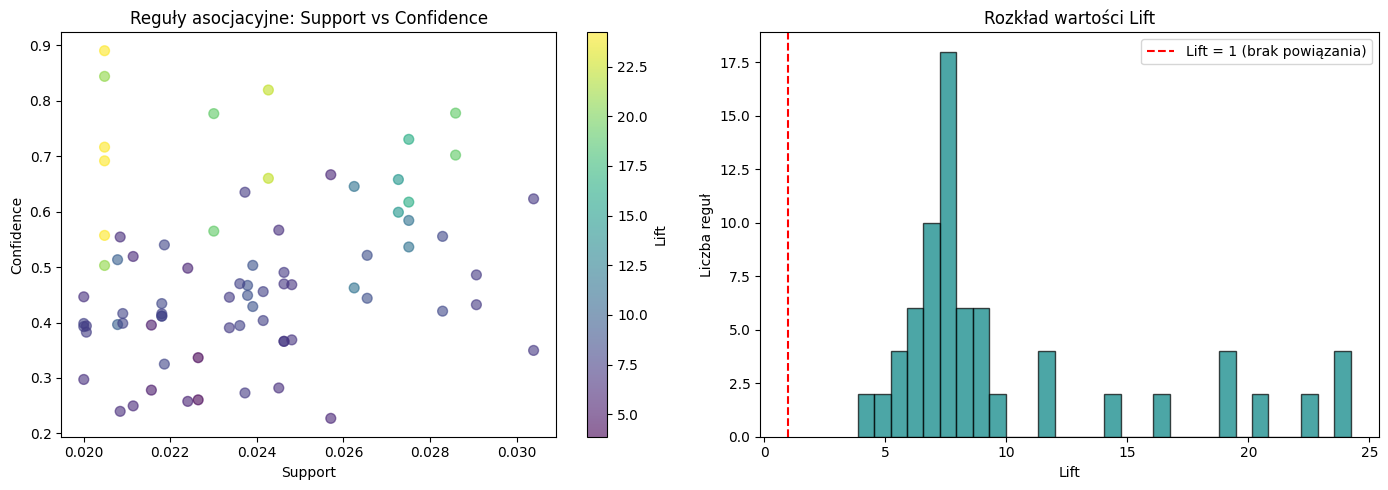


📊 Interpretacja:
   • Reguł z lift > 3 (silne powiązanie): 76
   • Reguł z confidence > 50%: 30
   • Średni lift: 10.19


In [6]:
# Wizualizacja reguł asocjacyjnych
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Support vs Confidence (kolor = Lift)
scatter = axes[0].scatter(
    rules['support'], 
    rules['confidence'], 
    c=rules['lift'], 
    cmap='viridis', 
    alpha=0.6,
    s=50
)
axes[0].set_xlabel('Support')
axes[0].set_ylabel('Confidence')
axes[0].set_title('Reguły asocjacyjne: Support vs Confidence')
plt.colorbar(scatter, ax=axes[0], label='Lift')

# Histogram lift
axes[1].hist(rules['lift'], bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[1].axvline(x=1, color='red', linestyle='--', label='Lift = 1 (brak powiązania)')
axes[1].set_xlabel('Lift')
axes[1].set_ylabel('Liczba reguł')
axes[1].set_title('Rozkład wartości Lift')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Interpretacja:")
print(f"   • Reguł z lift > 3 (silne powiązanie): {len(rules[rules['lift'] > 3])}")
print(f"   • Reguł z confidence > 50%: {len(rules[rules['confidence'] > 0.5])}")
print(f"   • Średni lift: {rules['lift'].mean():.2f}")

## 3. Przygotowanie cech RFM (Recency, Frequency, Monetary)

In [7]:
# Data referencyjna (dzień po ostatniej transakcji)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
print(f"Snapshot date: {snapshot_date}")

# Filtrowanie tylko dodatnich transakcji (bez zwrotów)
df_positive = df[df["TotalSum"] > 0]

# Agregacja RFM per klient
customer_df = df_positive.groupby(["CustomerID"]).agg(
    {
        "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
        "InvoiceNo": "nunique",  # Frequency (unikalne faktury)
        "TotalSum": "sum",  # Monetary
    }
)
customer_df.rename(
    columns={
        "InvoiceDate": "Recency",
        "InvoiceNo": "Frequency",
        "TotalSum": "Monetary",
    },
    inplace=True,
)

# Usunięcie klientów z ujemną lub zerową wartością Monetary
customer_df = customer_df[customer_df["Monetary"] > 0]

print(f"\nLiczba klientów do analizy: {len(customer_df)}")
print(f"\nStatystyki RFM (przed transformacją):")
customer_df.describe().round(2)

Snapshot date: 2011-12-10 12:50:00

Liczba klientów do analizy: 4338

Statystyki RFM (przed transformacją):


,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,92.54,4.27,2054.27
std,100.01,7.70,8989.23
min,1.00,1.00,3.75
25%,18.00,1.00,307.41
50%,51.00,2.00,674.48
75%,142.00,5.00,1661.74
max,374.00,209.00,280206.02


## 4. Transformacja logarytmiczna i standaryzacja

Transformacja `log(1+x)` redukuje wpływ outlierów i normalizuje rozkład cech.

In [8]:
# Transformacja log(1+x) dla wszystkich cech RFM
customer_df_log = customer_df.copy()
customer_df_log["Recency"] = np.log1p(customer_df["Recency"])
customer_df_log["Frequency"] = np.log1p(customer_df["Frequency"])
customer_df_log["Monetary"] = np.log1p(customer_df["Monetary"])

print("Statystyki RFM (po transformacji log):")
print(customer_df_log.describe().round(2))

# Standaryzacja
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_df_log)
customer_scaled_df = pd.DataFrame(
    customer_scaled, columns=customer_df.columns, index=customer_df.index
)

print("\nStatystyki RFM (po standaryzacji):")
customer_scaled_df.describe().round(2)

Statystyki RFM (po transformacji log):
       Recency  Frequency  Monetary
count  4338.00    4338.00   4338.00
mean      3.83       1.35      6.59
std       1.34       0.68      1.26
min       0.69       0.69      1.56
25%       2.94       0.69      5.73
50%       3.95       1.10      6.52
75%       4.96       1.79      7.42
max       5.93       5.35     12.54

Statystyki RFM (po standaryzacji):


,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.34,-0.96,-4.00
25%,-0.66,-0.96,-0.69
50%,0.09,-0.36,-0.06
75%,0.84,0.65,0.65
max,1.56,5.86,4.73


---
# 📉 E4: Redukcja wymiaru (PCA)

## 8. Analiza PCA - redukcja wymiarowości

In [9]:
# PCA - redukcja wymiaru z 3D do 2D dla wizualizacji
pca = PCA(n_components=2)
customer_pca = pca.fit_transform(customer_scaled_df)

# DataFrame z komponentami PCA
pca_df = pd.DataFrame(
    customer_pca, 
    columns=['PC1', 'PC2'],
    index=customer_df.index
)

# Wyjaśniona wariancja
print("📊 Analiza PCA - Redukcja wymiaru (3D → 2D)")
print("=" * 50)
print(f"\nWyjaśniona wariancja przez komponenty:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"   PC{i+1}: {var:.2%}")
print(f"   Łącznie: {sum(pca.explained_variance_ratio_):.2%}")

# Wagi cech w komponentach
print(f"\nWagi cech w komponentach głównych:")
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['Recency', 'Frequency', 'Monetary']
)
print(pca_loadings.round(3))

📊 Analiza PCA - Redukcja wymiaru (3D → 2D)

Wyjaśniona wariancja przez komponenty:
   PC1: 75.10%
   PC2: 18.76%
   Łącznie: 93.86%

Wagi cech w komponentach głównych:
             PC1    PC2
Recency   -0.512  0.850
Frequency  0.618  0.262
Monetary   0.597  0.457


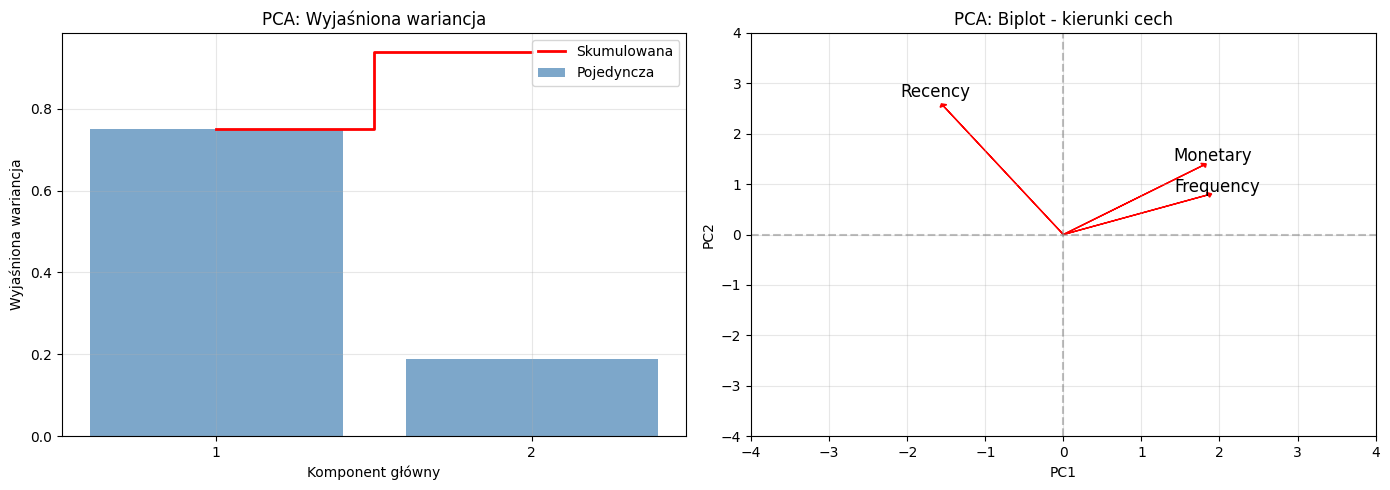

In [10]:
# Wizualizacja PCA - wyjaśniona wariancja
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres wariancji
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

axes[0].bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.7, label='Pojedyncza', color='steelblue')
axes[0].step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Skumulowana', color='red', linewidth=2)
axes[0].set_xlabel('Komponent główny')
axes[0].set_ylabel('Wyjaśniona wariancja')
axes[0].set_title('PCA: Wyjaśniona wariancja')
axes[0].set_xticks(range(1, len(variance_ratio) + 1))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Biplot - wagi cech
loadings = pca.components_.T
for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    axes[1].arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, 
                  head_width=0.1, head_length=0.05, fc='red', ec='red')
    axes[1].text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, fontsize=12, ha='center')

axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('PCA: Biplot - kierunki cech')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Wybór optymalnej liczby klastrów (Silhouette Score)

Analiza Silhouette Score:
k=2: Silhouette Score = 0.4329
k=3: Silhouette Score = 0.3365
k=4: Silhouette Score = 0.3371
k=5: Silhouette Score = 0.3161
k=6: Silhouette Score = 0.3133
k=7: Silhouette Score = 0.3100
k=8: Silhouette Score = 0.3008
k=9: Silhouette Score = 0.2817
k=10: Silhouette Score = 0.2787


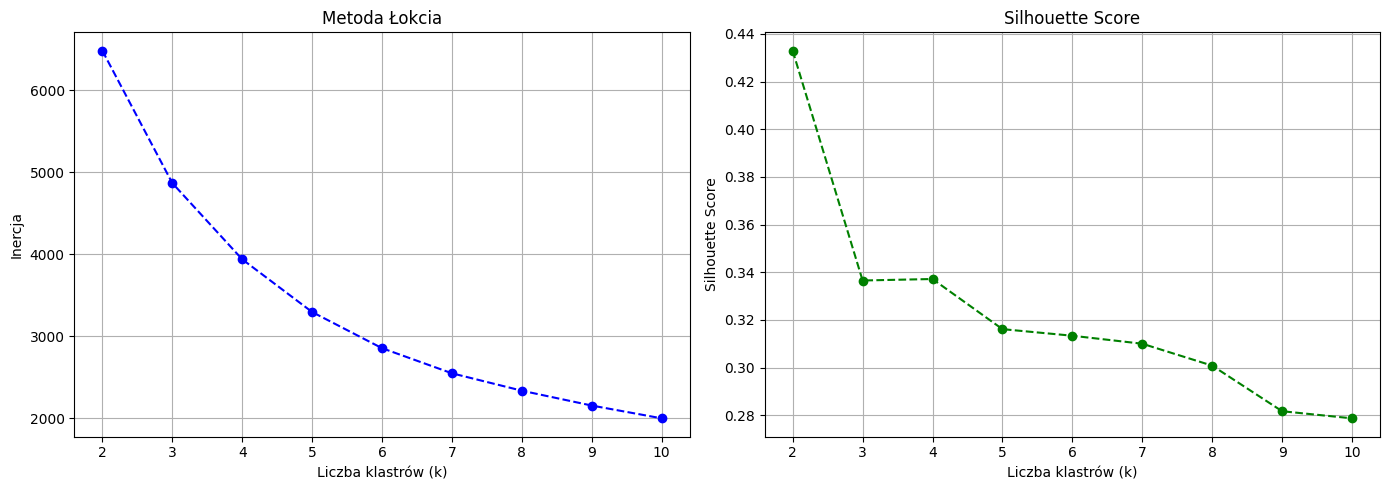


✓ Optymalna liczba klastrów wg Silhouette Score: 2


In [11]:
# Analiza Silhouette Score dla różnych wartości k
silhouette_scores = []
distortions = []
k_range = range(2, 11)

print("Analiza Silhouette Score:")
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_temp.fit_predict(customer_scaled_df)
    silhouette_avg = silhouette_score(customer_scaled_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    distortions.append(kmeans_temp.inertia_)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")

# Wykres
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Metoda łokcia
ax1.plot(k_range, distortions, marker="o", linestyle="--", color="b")
ax1.set_title("Metoda Łokcia")
ax1.set_xlabel("Liczba klastrów (k)")
ax1.set_ylabel("Inercja")
ax1.grid(True)

# Silhouette score
ax2.plot(k_range, silhouette_scores, marker="o", linestyle="--", color="g")
ax2.set_title("Silhouette Score")
ax2.set_xlabel("Liczba klastrów (k)")
ax2.set_ylabel("Silhouette Score")
ax2.grid(True)

plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optymalna liczba klastrów wg Silhouette Score: {optimal_k}")

## 6. Klasteryzacja K-Means

In [12]:
# K-Means z optymalną liczbą klastrów
print(f"K-Means z k={optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(customer_scaled_df)
customer_df["Cluster"] = clusters

print("\nLiczebność klastrów:")
print(customer_df["Cluster"].value_counts().sort_index())

print("\nŚrednie wartości RFM w klastrach:")
cluster_summary = customer_df.groupby("Cluster").agg(
    {
        "Recency": ["mean", "std", "min", "max"],
        "Frequency": ["mean", "std", "min", "max"],
        "Monetary": ["mean", "std", "min", "max"],
    }
)
cluster_summary.round(2)

K-Means z k=2

Liczebność klastrów:
Cluster
0    2671
1    1667
Name: count, dtype: int64

Średnie wartości RFM w klastrach:


Recency                 Frequency                 Monetary            \
           mean    std min  max      mean    std min  max     mean       std   
Cluster                                                                        
0        134.14  105.3   1  374      1.67   0.91   1    7   497.74    462.42   
1         25.88   32.4   1  372      8.44  11.17   1  209  4548.26  14138.86   

                            
            min        max  
Cluster                     
0          3.75    4959.10  
1        201.12  280206.02

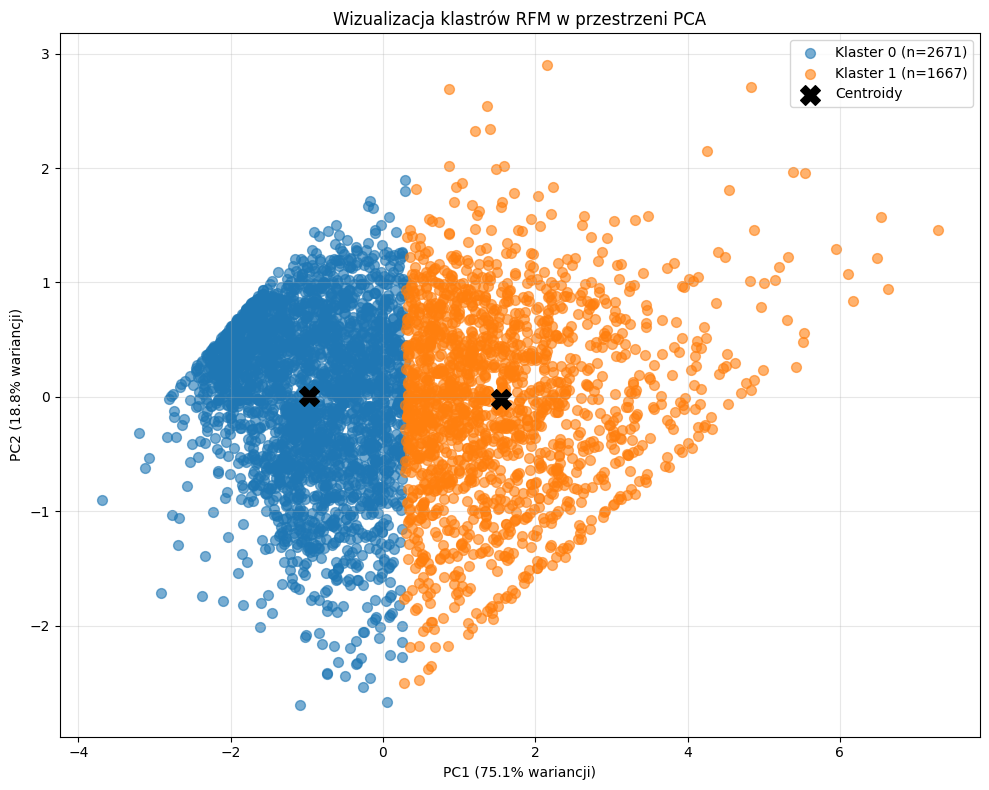


📊 PCA umożliwia wizualizację 3-wymiarowych danych RFM w 2D
   zachowując 93.9% oryginalnej wariancji


In [13]:
# Wizualizacja klastrów w przestrzeni PCA (2D)
pca_df['Cluster'] = customer_df['Cluster']

plt.figure(figsize=(10, 8))
for cluster in sorted(pca_df['Cluster'].unique()):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(
        cluster_data['PC1'], 
        cluster_data['PC2'], 
        label=f'Klaster {cluster} (n={len(cluster_data)})',
        alpha=0.6,
        s=50
    )

# Centroidy klastrów
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='black', marker='X', s=200, label='Centroidy')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)')
plt.title('Wizualizacja klastrów RFM w przestrzeni PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 PCA umożliwia wizualizację 3-wymiarowych danych RFM w 2D")
print(f"   zachowując {sum(pca.explained_variance_ratio_):.1%} oryginalnej wariancji")

## 7. Analiza jakości klastrowania (Silhouette per sample)

In [14]:
# Silhouette Score per sample
silhouette_vals = silhouette_samples(customer_scaled_df, clusters)
customer_df["Silhouette"] = silhouette_vals

print("Średni Silhouette Score per klaster:")
for cluster in sorted(customer_df["Cluster"].unique()):
    cluster_silhouette = customer_df[customer_df["Cluster"] == cluster]["Silhouette"].mean()
    cluster_size = (customer_df["Cluster"] == cluster).sum()
    print(f"Klaster {cluster} (n={cluster_size}): {cluster_silhouette:.4f}")

# Wykrycie outlierów (Silhouette < 0 oznacza źle przypisany punkt)
outliers = customer_df[customer_df["Silhouette"] < 0]
print(f"\n⚠️  Liczba potencjalnych outlierów (Silhouette < 0): {len(outliers)}")
print(f"   To stanowi {len(outliers)/len(customer_df)*100:.2f}% danych")

if len(outliers) > 0:
    print("\nRozkład outlierów per klaster:")
    print(outliers["Cluster"].value_counts().sort_index())

Średni Silhouette Score per klaster:
Klaster 0 (n=2671): 0.4817
Klaster 1 (n=1667): 0.3548

⚠️  Liczba potencjalnych outlierów (Silhouette < 0): 58
   To stanowi 1.34% danych

Rozkład outlierów per klaster:
Cluster
1    58
Name: count, dtype: int64


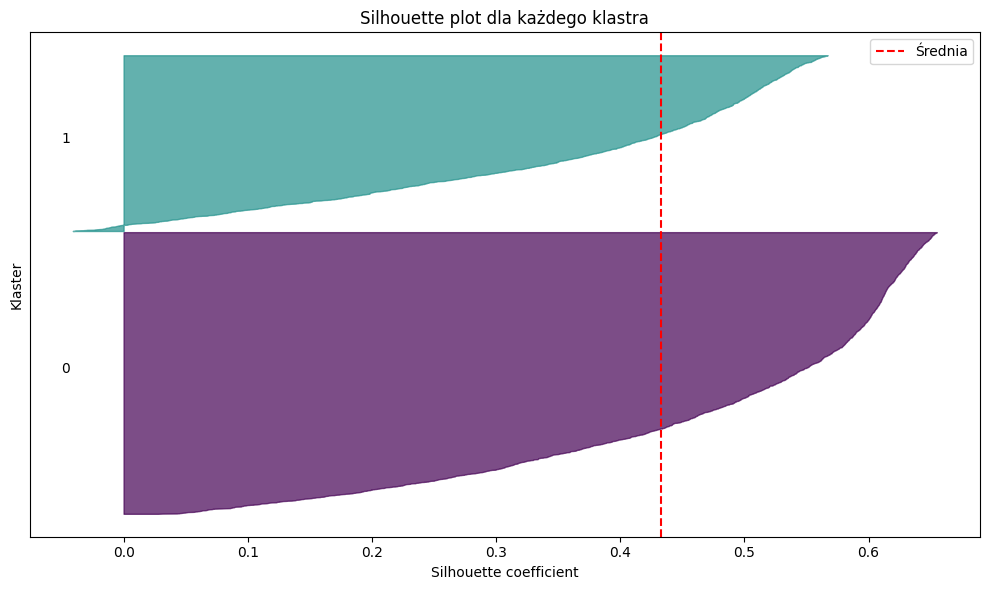

In [15]:
# Wizualizacja Silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

for cluster in sorted(customer_df["Cluster"].unique()):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster]
    cluster_silhouette_vals.sort()

    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster

    color = plt.cm.viridis(cluster / optimal_k)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
    y_lower = y_upper + 10

ax.set_title("Silhouette plot dla każdego klastra")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Klaster")
ax.axvline(x=silhouette_score(customer_scaled_df, clusters), color="red", linestyle="--", label="Średnia")
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.show()

## 8. Interpretacja biznesowa klastrów

In [16]:
print("=" * 80)
print("INTERPRETACJA BIZNESOWA KLASTRÓW")
print("=" * 80)

for cluster in sorted(customer_df["Cluster"].unique()):
    cluster_data = customer_df[customer_df["Cluster"] == cluster]
    print(f"\n📊 KLASTER {cluster} ({len(cluster_data)} klientów, {len(cluster_data)/len(customer_df)*100:.1f}%)")
    print(f"   Recency: {cluster_data['Recency'].mean():.0f} dni (±{cluster_data['Recency'].std():.0f})")
    print(f"   Frequency: {cluster_data['Frequency'].mean():.1f} transakcji (±{cluster_data['Frequency'].std():.1f})")
    print(f"   Monetary: £{cluster_data['Monetary'].mean():.0f} (±£{cluster_data['Monetary'].std():.0f})")
    print(f"   Silhouette: {cluster_data['Silhouette'].mean():.3f}")
    
    # Etykieta biznesowa
    if cluster_data["Recency"].mean() < 50 and cluster_data["Monetary"].mean() > 5000:
        label = "💎 VIP - Najcenniejsi klienci"
    elif cluster_data["Recency"].mean() < 50:
        label = "✓ Aktywni - Regularni klienci"
    elif cluster_data["Recency"].mean() > 150:
        label = "💤 Śpiący - Ryzyko churn"
    else:
        label = "⚠️  Wymagający uwagi"
    print(f"   Etykieta: {label}")

INTERPRETACJA BIZNESOWA KLASTRÓW

📊 KLASTER 0 (2671 klientów, 61.6%)
   Recency: 134 dni (±105)
   Frequency: 1.7 transakcji (±0.9)
   Monetary: £498 (±£462)
   Silhouette: 0.482
   Etykieta: ⚠️  Wymagający uwagi

📊 KLASTER 1 (1667 klientów, 38.4%)
   Recency: 26 dni (±32)
   Frequency: 8.4 transakcji (±11.2)
   Monetary: £4548 (±£14139)
   Silhouette: 0.355
   Etykieta: ✓ Aktywni - Regularni klienci


---
# 🌲 Walidacja Random Forest

## 9. Przygotowanie danych treningowych i testowych (podział czasowy)

In [17]:
# Podział czasowy
train_cutoff = pd.Period("2011-09", freq="M")

df_positive_train = df_positive[df_positive["YearMonth"] <= train_cutoff]
df_positive_test = df_positive[df_positive["YearMonth"] > train_cutoff]

print(f"Trening: {df_positive_train['YearMonth'].min()} - {df_positive_train['YearMonth'].max()}")
print(f"Test: {df_positive_test['YearMonth'].min()} - {df_positive_test['YearMonth'].max()}")

# RFM dla okresu treningowego
snapshot_train = df_positive_train["InvoiceDate"].max() + pd.Timedelta(days=1)
customer_train = df_positive_train.groupby(["CustomerID"]).agg({
    "InvoiceDate": lambda x: (snapshot_train - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalSum": "sum",
})
customer_train.rename(
    columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "TotalSum": "Monetary"},
    inplace=True,
)
customer_train = customer_train[customer_train["Monetary"] > 0]

# Transformacja log dla treningu
customer_train_log = customer_train.copy()
customer_train_log["Recency"] = np.log1p(customer_train["Recency"])
customer_train_log["Frequency"] = np.log1p(customer_train["Frequency"])
customer_train_log["Monetary"] = np.log1p(customer_train["Monetary"])

# RFM dla okresu testowego
snapshot_test = df_positive_test["InvoiceDate"].max() + pd.Timedelta(days=1)
customer_test = df_positive_test.groupby(["CustomerID"]).agg({
    "InvoiceDate": lambda x: (snapshot_test - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalSum": "sum",
})
customer_test.rename(
    columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "TotalSum": "Monetary"},
    inplace=True,
)
customer_test = customer_test[customer_test["Monetary"] > 0]

# Transformacja log dla testu
customer_test_log = customer_test.copy()
customer_test_log["Recency"] = np.log1p(customer_test["Recency"])
customer_test_log["Frequency"] = np.log1p(customer_test["Frequency"])
customer_test_log["Monetary"] = np.log1p(customer_test["Monetary"])

# Standaryzacja
scaler_temporal = StandardScaler()
customer_train_scaled = scaler_temporal.fit_transform(customer_train_log)
customer_test_scaled = scaler_temporal.transform(customer_test_log)

print(f"\nKlienci w treningu: {len(customer_train)}")
print(f"Klienci w teście: {len(customer_test)}")

Trening: 2010-12 - 2011-09
Test: 2011-10 - 2011-12

Klienci w treningu: 3616
Klienci w teście: 2560


## 10. Tworzenie ground truth dla obu okresów

In [18]:
# K-Means na danych treningowych
kmeans_train = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_train["Cluster"] = kmeans_train.fit_predict(customer_train_scaled)

# Używamy TEGO SAMEGO modelu K-Means do przypisania klastrów w okresie testowym
# To zapewnia spójność etykiet między okresami
customer_test["Cluster"] = kmeans_train.predict(customer_test_scaled)

print("Rozkład klastrów (trening):")
print(customer_train["Cluster"].value_counts().sort_index())

print("\nRozkład klastrów (test):")
print(customer_test["Cluster"].value_counts().sort_index())

# Wspólni klienci
common_customers = customer_train.index.intersection(customer_test.index)
print(f"\nWspólni klienci (do walidacji): {len(common_customers)}")

Rozkład klastrów (trening):
Cluster
0    1338
1    2278
Name: count, dtype: int64

Rozkład klastrów (test):
Cluster
0     810
1    1750
Name: count, dtype: int64

Wspólni klienci (do walidacji): 1838


## 11. Trening Random Forest i Baseline

In [19]:
# Przygotowanie danych - konwersja na DataFrame dla poprawnego indeksowania
customer_train_scaled_df = pd.DataFrame(
    customer_train_scaled, 
    columns=["Recency", "Frequency", "Monetary"],
    index=customer_train.index
)
customer_test_scaled_df = pd.DataFrame(
    customer_test_scaled, 
    columns=["Recency", "Frequency", "Monetary"],
    index=customer_test.index
)

X_train = customer_train_scaled_df
y_train = customer_train["Cluster"]

# Filtrowanie tylko wspólnych klientów dla testu
X_test = customer_test_scaled_df.loc[common_customers]
y_test = customer_test.loc[common_customers, "Cluster"]

print(f"Rozmiar zbioru treningowego: {len(X_train)}")
print(f"Rozmiar zbioru testowego: {len(X_test)}")

print("\nRozkład klas w zbiorze treningowym:")
print(pd.Series(y_train).value_counts(normalize=True).round(3))
print("\nRozkład klas w zbiorze testowym:")
print(pd.Series(y_test).value_counts(normalize=True).round(3))

# Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Baseline model (dla porównania)
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

# Predykcje
y_pred_rf = clf.predict(X_test)
y_pred_baseline = baseline.predict(X_test)

print("\n✓ Modele wytrenowane!")

Rozmiar zbioru treningowego: 3616
Rozmiar zbioru testowego: 1838

Rozkład klas w zbiorze treningowym:
Cluster
1    0.63
0    0.37
Name: proportion, dtype: float64

Rozkład klas w zbiorze testowym:
Cluster
1    0.63
0    0.37
Name: proportion, dtype: float64

✓ Modele wytrenowane!


## 12. Ewaluacja modeli i macierz pomyłek

In [20]:
print("=" * 80)
print("WYNIKI - BASELINE MODEL (zawsze przewiduje najczęstszą klasę)")
print("=" * 80)
print(classification_report(y_test, y_pred_baseline, zero_division=0))

print("\n" + "=" * 80)
print("WYNIKI - RANDOM FOREST")
print("=" * 80)
print(classification_report(y_test, y_pred_rf, zero_division=0))

WYNIKI - BASELINE MODEL (zawsze przewiduje najczęstszą klasę)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       680
           1       0.63      1.00      0.77      1158

    accuracy                           0.63      1838
   macro avg       0.32      0.50      0.39      1838
weighted avg       0.40      0.63      0.49      1838


WYNIKI - RANDOM FOREST
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       680
           1       0.98      1.00      0.99      1158

    accuracy                           0.99      1838
   macro avg       0.99      0.98      0.99      1838
weighted avg       0.99      0.99      0.99      1838



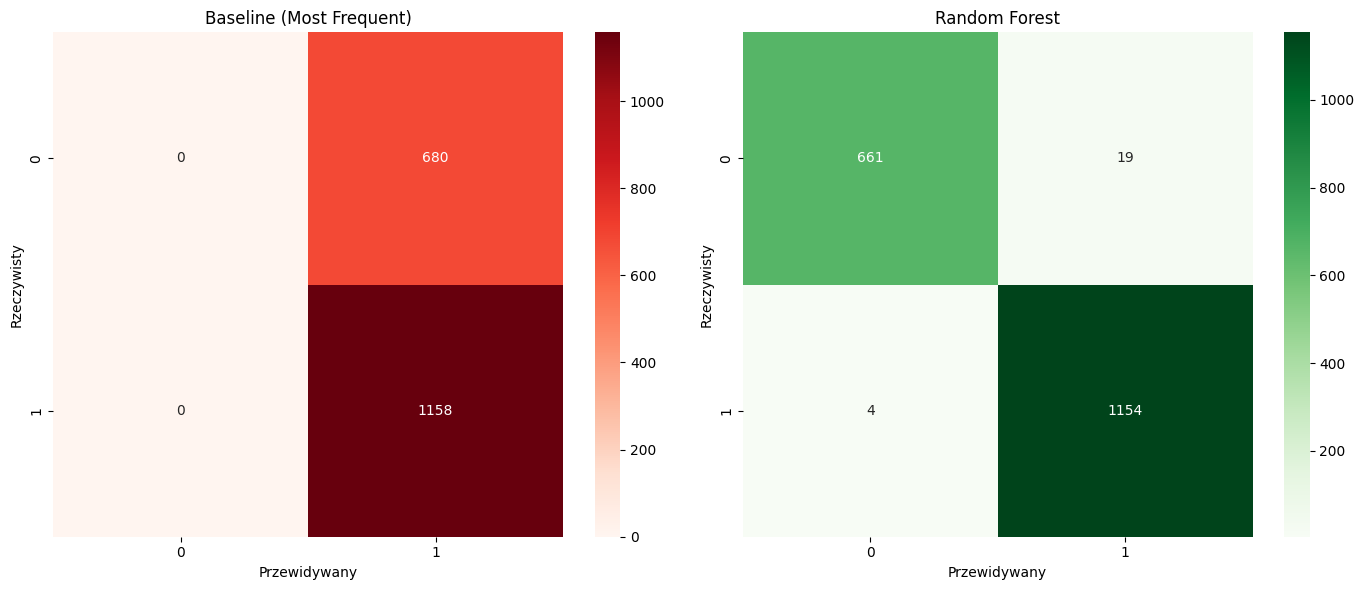

In [21]:
# Macierz pomyłek
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Baseline
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt="d",
    cmap="Reds",
    ax=ax1,
    xticklabels=range(optimal_k),
    yticklabels=range(optimal_k),
)
ax1.set_title("Baseline (Most Frequent)")
ax1.set_xlabel("Przewidywany")
ax1.set_ylabel("Rzeczywisty")

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    ax=ax2,
    xticklabels=range(optimal_k),
    yticklabels=range(optimal_k),
)
ax2.set_title("Random Forest")
ax2.set_xlabel("Przewidywany")
ax2.set_ylabel("Rzeczywisty")

plt.tight_layout()
plt.show()

## 13. Ważność cech (Feature Importance)

📊 Ważność cech:
Monetary     0.347369
Frequency    0.344290
Recency      0.308341
dtype: float64


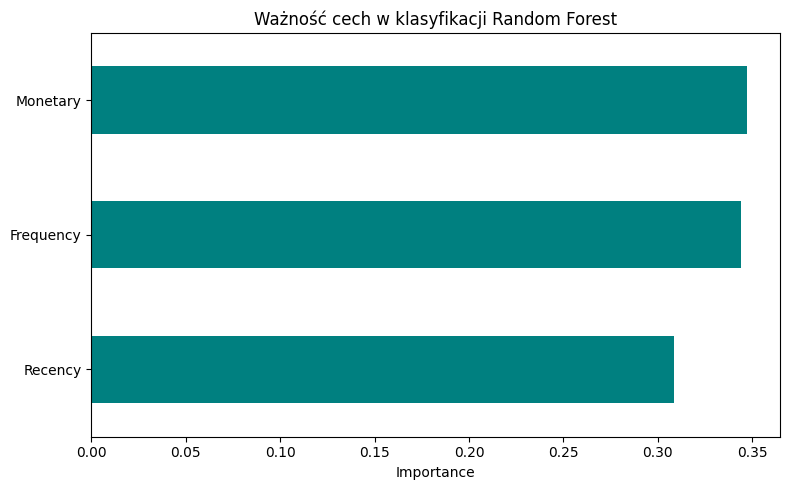

In [22]:
# Feature importance
feature_importance = pd.Series(
    clf.feature_importances_, index=["Recency", "Frequency", "Monetary"]
)
print("📊 Ważność cech:")
print(feature_importance.sort_values(ascending=False))

plt.figure(figsize=(8, 5))
feature_importance.sort_values().plot(kind="barh", color="teal")
plt.title("Ważność cech w klasyfikacji Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## 14. Analiza stabilności segmentów w czasie

Macierz przejść między okresami (%):
Wiersz = segment w okresie 1, Kolumna = segment w okresie 2
Cluster_Period2     0     1
Cluster_Period1            
0                51.6  48.4
1                20.1  79.9


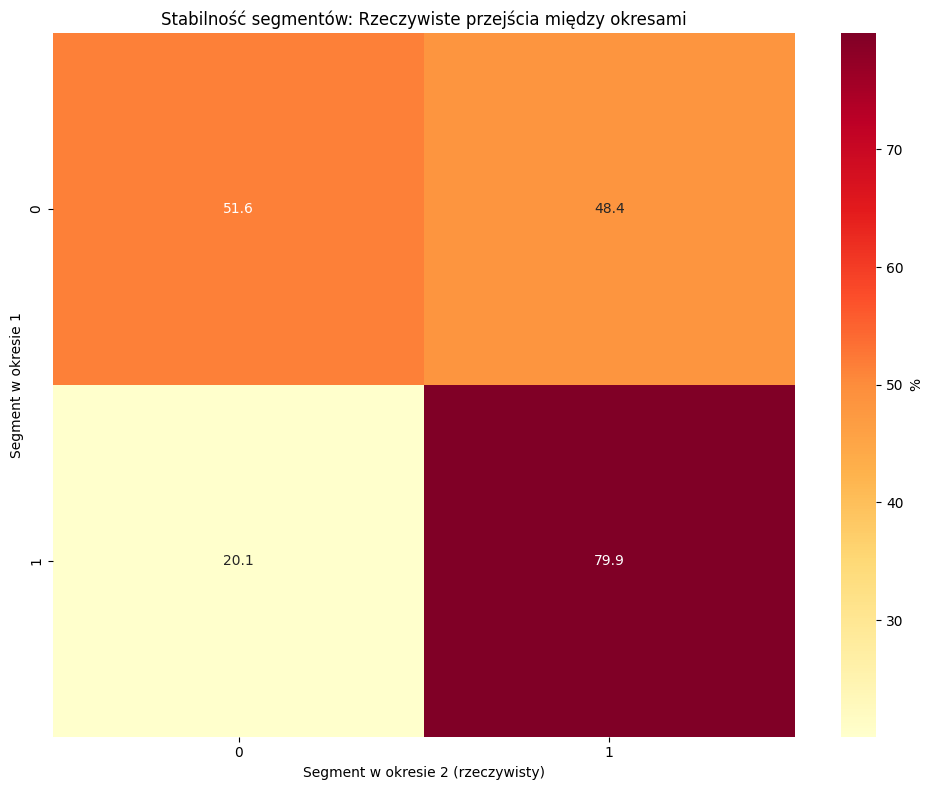


📊 Średnia stabilność segmentów: 65.7%
(% klientów pozostających w tym samym segmencie)


In [23]:
# Macierz przejść RZECZYWISTYCH (nie predykcji!)
customer_common = pd.DataFrame({
    "Cluster_Period1": customer_train.loc[common_customers, "Cluster"],
    "Cluster_Period2": customer_test.loc[common_customers, "Cluster"],
})

transition_matrix = pd.crosstab(
    customer_common["Cluster_Period1"],
    customer_common["Cluster_Period2"],
    normalize="index",
) * 100

print("Macierz przejść między okresami (%):")
print("Wiersz = segment w okresie 1, Kolumna = segment w okresie 2")
print(transition_matrix.round(1))

# Wizualizacja
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={"label": "%"})
plt.title("Stabilność segmentów: Rzeczywiste przejścia między okresami")
plt.xlabel("Segment w okresie 2 (rzeczywisty)")
plt.ylabel("Segment w okresie 1")
plt.tight_layout()
plt.show()

# Statystyki stabilności
stability = np.diag(transition_matrix).mean()
print(f"\n📊 Średnia stabilność segmentów: {stability:.1f}%")
print("(% klientów pozostających w tym samym segmencie)")

## 15. Podsumowanie i wnioski

In [24]:
print("=" * 80)
print("📋 PODSUMOWANIE ANALIZY")
print("=" * 80)

print("\n✅ E5 - REGUŁY ASOCJACYJNE (Apriori):")
print(f"   • Algorytm: Apriori z min_support=0.02")
print(f"   • Metryki: Support, Confidence, Lift")
print(f"   • Zastosowanie: Market Basket Analysis - rekomendacje produktów")

print("\n✅ E4 - REDUKCJA WYMIARU (PCA):")
print(f"   • Redukcja: 3D (RFM) → 2D (PC1, PC2)")
print(f"   • Wyjaśniona wariancja: {sum(pca.explained_variance_ratio_):.1%}")
print(f"   • Zastosowanie: Wizualizacja klastrów klientów")

print("\n✅ E5 - GRUPOWANIE (K-Means):")
print(f"   • Optymalna liczba klastrów: {optimal_k} (wg Silhouette Score)")
print(f"   • Średni Silhouette Score: {silhouette_score(customer_scaled_df, clusters):.3f}")
print(f"   • Outliers (Silhouette < 0): {len(outliers)} ({len(outliers)/len(customer_df)*100:.1f}%)")

print("\n✅ E5 - KLASYFIKACJA (Random Forest):")
print(f"   • Walidacja czasowa z poprawnym ground truth")
print(f"   • Stabilność segmentów: {stability:.1f}%")
print(f"   • Porównanie z baseline model (DummyClassifier)")

print("\n" + "=" * 80)
print("🎯 WNIOSKI")
print("=" * 80)

print("\n📦 Reguły asocjacyjne:")
print("   • Zidentyfikowano produkty często kupowane razem")
print("   • Zastosowanie: systemy rekomendacji, cross-selling")

print("\n📉 Redukcja wymiaru:")
print("   • PCA pozwala wizualizować wielowymiarowe dane klientów")
print("   • Ułatwia interpretację i prezentację wyników klastrowania")

print("\n👥 Segmentacja klientów:")
if stability > 60:
    print("   • Segmenty są względnie stabilne - model ma sens")
elif stability > 40:
    print("   • Średnia stabilność - model działa częściowo")
else:
    print("   • Niska stabilność - sezonowość dominuje nad segmentacją")

print("\n📊 Kluczowe metryki:")
print(f"   • Silhouette Score: {silhouette_score(customer_scaled_df, clusters):.3f}")
print(f"   • Stabilność segmentów: {stability:.1f}%")

📋 PODSUMOWANIE ANALIZY

✅ E5 - REGUŁY ASOCJACYJNE (Apriori):
   • Algorytm: Apriori z min_support=0.02
   • Metryki: Support, Confidence, Lift
   • Zastosowanie: Market Basket Analysis - rekomendacje produktów

✅ E4 - REDUKCJA WYMIARU (PCA):
   • Redukcja: 3D (RFM) → 2D (PC1, PC2)
   • Wyjaśniona wariancja: 93.9%
   • Zastosowanie: Wizualizacja klastrów klientów

✅ E5 - GRUPOWANIE (K-Means):
   • Optymalna liczba klastrów: 2 (wg Silhouette Score)
   • Średni Silhouette Score: 0.433
   • Outliers (Silhouette < 0): 58 (1.3%)

✅ E5 - KLASYFIKACJA (Random Forest):
   • Walidacja czasowa z poprawnym ground truth
   • Stabilność segmentów: 65.7%
   • Porównanie z baseline model (DummyClassifier)

🎯 WNIOSKI

📦 Reguły asocjacyjne:
   • Zidentyfikowano produkty często kupowane razem
   • Zastosowanie: systemy rekomendacji, cross-selling

📉 Redukcja wymiaru:
   • PCA pozwala wizualizować wielowymiarowe dane klientów
   • Ułatwia interpretację i prezentację wyników klastrowania

👥 Segmentacja kli